# Analysis of Ripple transaction data for 7 days from 21st May 2017 - 28th May 2017

In [1]:
import csv
import random
import tqdm
import datetime
import pandas as pd
from dict_tools import *

In [55]:
#FUNCTIONS
def coarsen_time(timestamp,degree):
    '''Coarsen time by the degree `degree`.
    Degree is either 'd' (day), 'm' (minute), 'h' (hour), 's' (second), or False (exclude)
    '''
    if degree == 'd':
        return timestamp[0:10]
    elif degree == 'h':
        return timestamp[0:13]
    elif degree == 'm':
        return timestamp[0:16]
    elif degree == 's':
        return timestamp[0:19]
    else:
        return None
        
unknown_curr = set()
def coarsen_amount(amount,degree,currency):
    '''Coarsen amount by the degree `degree`, which depends on the strength of\
        the `currency`. 
        `degree` can take:
        'm'" max, 'h': High, 'm': Medium, 'l': low
        
        Note that strength is not checked online, so it may not\
        be accurate if the strength of a currency has changed dramatically
        
        Note that rounding may not be perfect owing to floating point issues
    '''
    #Strength of currencies in 2014, I'm going to check these (I think XRP is \
    # now about as strong as the pound)
    
    strong_curr = ('BTC', 'XAG','XAU', 'XPT')
    med_curr = ('CNY','EUR','USD','AUD','GBP','JPY','XRP') #<- XRP DIFFERENT TO ORIGINAL PAPER
    weak_curr = ('CCK','STR','KRW','MTL')
    
    lookup_strong = {'h': 1e-3, 'a': 1e-2, 'l': 1e-1}
    lookup_med = {'h': 1e1, 'a': 1e2, 'l': 1e3}
    lookup_weak = {'h': 1e5, 'a': 1e6, 'l': 1e7}
    if degree is False:
        return None
    elif degree == 'm':
        return amount
    else:
        if currency in strong_curr:
            prec = lookup_strong[degree]
        elif currency in med_curr:
            prec = lookup_med[degree]
        elif currency in weak_curr:
            prec = lookup_weak[degree]
        else:
            unknown_curr.add(currency)
            #print("Unknown currency {}".format(currency))
            prec = 1
    
        coarse_amount = float(int(round(amount/prec)))*prec

        return coarse_amount


def by_point(data_by_sender):
    data_by_point = {}
    for sender in data_by_sender:
        for datapoint in data_by_sender[sender]:
            if datapoint not in data_by_point:
                data_by_point[datapoint] = set()
            data_by_point[datapoint].add(sender)
    return data_by_point

In [3]:
#LOAD DATA
f1 = 'ripple_week1.csv'
files = [f1]

#start_date = datetime.date(2013,1,1)
#end_date = datetime.date(2013,4,22)
#date_list = pd.date_range(start_date,end_date,freq="1D")
#
#files = []
#for day in date_list:
#    print("Current date: {}".format(day.strftime("%Y-%m-%d")))
#    this_day = day.strftime("%Y-%m-%d")
#    next_day = (day+datetime.timedelta(days=1)).strftime("%Y-%m-%d")
#    files.append("Ripple_transactions_{}_to_{}.csv".format(this_day,next_day))

def load_data_by_sender(files,a_res,include_c,t_res,include_d):
    '''Create dictionary from a list of file names `file` \
        with keys being senders and datapoints by tuple \
        (Amount, Currency, Time, Destination)'''
    data_by_sender = {}
    for file in files:
        i = 0
        print(file)
        for line in tqdm.tqdm(csv.reader(open(file,'r'))):
            if i == 0:
                header = line
            else:
                sender = line[header.index('Sender')]
                
                
                curr = line[header.index('Currency')]
                amount = coarsen_amount(float(line[header.index('Amount')]),a_res,curr)   #<- COARSENING 
                time = coarsen_time(line[header.index('Timestamp')],t_res)       #<- COARSENING
                if include_d:
                    destination = line[header.index('Destination')]
                else:
                    destination = None
                if not include_c:
                    curr = None
                datapoint = tuple([amount,curr,time,destination])
                
                if sender not in data_by_sender:
                    data_by_sender[sender] = set() 
                data_by_sender[sender].add(tuple(datapoint))
            i+=1
    return data_by_sender

In [8]:
def get_points_to_users(dataset):
    """
    Returns a dictionary mapping the datapoints (antenna,time) pairs to the users who
    were recorded at that datapoint
    
    In other words, this reverses the dictionary from 'dataset'
    """
    new_data= {}
    for user in dataset:
        for point in dataset[user]:
            if point not in new_data:
                new_data[point] = set([user])
            else:
                new_data[point].add(user)
    return new_data

def get_unicity(dataset,p,npeople):
    """
    Returns unicity (float) of 'dataset' (dict), where 'p' is number of points sampled
    """
    
    if npeople != "all":
        npeople = int(npeople)
    else:
        npeople = len(dataset)
        
    #dataset = {0:set([(antenna1,time1),(antenna2,time2),etc.]),
    #           1:set([(antenna1,time1),(antenna2,time2),etc.]),...etc.}
    points_to_users = get_points_to_users(dataset)
    print("User number: ",len(dataset))
    print("Point number: ",len(points_to_users))
    count = 0
    unique_users = set()
    users = random.sample(list(dataset.keys()),npeople)
    
    users_included = set() #<- Users with at least p points
#    print(users)
    for u in users:
#        print(u)
        u_data = dataset[u]
#        print(list(u_data))
        if len(u_data) < p: # <- NOT 
            continue
        else:
            p_points = random.sample(u_data,p)
            users_included.add(u)
        is_unique = True
        
        similar_people = set(dataset.keys())
#        print(p_points)
        for point in p_points:
#            print(points_to_users[point])
#            print(len(points_to_users[point]),len(similar_people))
            similar_people = similar_people.intersection(points_to_users[point])
#        print(similar_people)
#        print(u)
    

        if len(similar_people) > 1:
            is_unique = False
            continue #<-NEED TO CONTINUE NOT BREAK!
        
        if is_unique:
            #print(u)
            unique_users.add(u) 
        count += 1
    print("Users included:",len(users_included))
    return len(unique_users)/len(users_included) #<-COMPARING WITH NUMBER OF USERS WITH AT LEAST p POINTS

# Notes to self

In [ ]:
#Options for Accuracy (acc)
curr_acc = 'm' #m = max, a=av, l=low
t_acc = 'd'    #'d' (day), 'm' (minute), 's' (second)

In [17]:
help(load_data_by_sender)

Help on function load_data_by_sender in module __main__:

load_data_by_sender(files, a_res, include_c, t_res, include_d)
    Create dictionary from a list of file names `file`         with keys being senders and datapoints by tuple         (Amount, Currency, Time, Destination)



* XRP counted as being a low value currency in 2014 paper, but it has become comparable to the pound. Tested
* User behaviour may have changed

# Am  C Tsc D

Paper: "we are able to determine uniquely more than 99.83% of transaction sender addresses."

In [144]:
data_by_sender = load_data_by_sender(files,'m',True,'s',True)
data_by_point = by_point(data_by_sender)

#Number of senders
print("Number of senders: {} (check against stats from get_unicity)".format(len(data_by_sender)))
print("Number of different datapoints: {} (check against stats from get_unicity)".format(len(data_by_point)))

ripple_week1.csv


213077it [00:02, 100487.75it/s]


Number of senders: 20447 (check against stats from get_unicity)
Number of different datapoints: 208879 (check against stats from get_unicity)


In [58]:
get_unicity(data_by_sender,1,1e4)

User number:  20447
Point number:  208879
Users included: 10000


0.9901

In [56]:
#Unicity w/ low XRP: 0.9903

# Am  - Tsc D

Paper: "we can still de-anonymize the sender account for 99.83% of the transactions"

In [51]:
data_by_sender = load_data_by_sender(files,'m',False,'s',True)

data_by_point = by_point(data_by_sender)

#Number of senders
print("Number of senders: {} (check against stats from get_unicity)".format(len(data_by_sender)))
print("Number of different datapoints: {} (check against stats from get_unicity)".format(len(data_by_point)))

ripple_week1.csv


213077it [00:02, 104096.14it/s]


Number of senders: 20447 (check against stats from get_unicity)
Number of different datapoints: 208879 (check against stats from get_unicity)


In [52]:
get_unicity(data_by_sender,1,1e4)

User number:  20447
Point number:  208879
Users included: 10000


0.9906

# Am C Tsc -

Paper: "the percentage of unique payments slightly decreases to 93.78%.

In [53]:
data_by_sender = load_data_by_sender(files,'m',True,'s',False)

data_by_point = by_point(data_by_sender)

#Number of senders
print("Number of senders: {} (check against stats from get_unicity)".format(len(data_by_sender)))
print("Number of different datapoints: {} (check against stats from get_unicity)".format(len(data_by_point)))

ripple_week1.csv


213077it [00:02, 96033.42it/s] 


Number of senders: 20447 (check against stats from get_unicity)
Number of different datapoints: 202841 (check against stats from get_unicity)


In [54]:
get_unicity(data_by_sender,1,1e4)

User number:  20447
Point number:  202841
Users included: 10000


0.9827

# - C Tsc D

Paper: "drops to 89:86%"

In [156]:
data_by_sender = load_data_by_sender(files,False,True,'s',True)

data_by_point = by_point(data_by_sender)

#Number of senders
print("Number of senders: {} (check against stats from get_unicity)".format(len(data_by_sender)))
print("Number of different datapoints: {} (check against stats from get_unicity)".format(len(data_by_point)))

ripple_week1.csv


213077it [00:02, 99538.38it/s] 


Number of senders: 20447 (check against stats from get_unicity)
Number of different datapoints: 196419 (check against stats from get_unicity)


In [174]:
_TscCD = get_unicity(data_by_sender,1,1e4)
print(_TscCD)

User number:  20447
Point number:  196419
Users included: 10000
0.7217


> Significantly different to paper

In [175]:
def by_time(data_by_sender):
    data_by_time = {}
    for sender in data_by_sender:
        for datapoint in data_by_sender[sender]:
            time = datapoint[2]
            if time not in data_by_time:
                data_by_time[time] = set()
            data_by_time[time].add(sender)
    return data_by_time

Sort into a dict of time, # of senders at a time

In [171]:
users_by_time = by_time(data_by_sender)

In [172]:
dict_sample(users_by_time)

[('2017-05-21T12:55:21',
  {'r3mjvvDqHu63vHueSTZXB6gtqVSKrHpLu3',
   'rhPQwaCHxDhuNYKd6rPrT5sCZ21AgX4tg3'}),
 ('2017-05-24T22:27:40',
  {'rByVBP2LsLyvt2xZm86voQgbKvdqpE9hJG',
   'rDsbeomae4FXwgQTJp9Rs64Qg9vDiTCdBv'})]

In [196]:
maxm = 0
peak_time = ''
data_by_time_agg = {}
for time in users_by_time.keys():
    data_by_time_agg[time] = len(data_by_time[time])
    count = len(users_by_time[time])
    if count > maxm:
        maxm = count
        peak_time = time


C:\Users\admin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


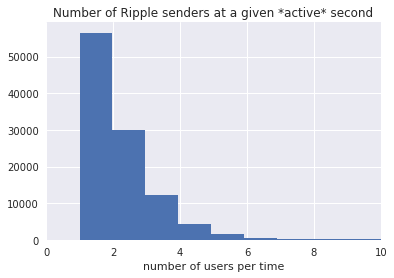

In [227]:
plt.figure()
plt.title("Number of Ripple senders at a given *active* second")
hist = plt.hist(list(data_by_time_agg.values()),bins=57)
plt.xlim([0,10])
plt.xlabel('number of users per time')

In [225]:
print("Number of active seconds during which there is only one sender recorded as having made a transaction:",hist[0][0])
print(hist[0][0]/len(data_by_time_agg))

Number of active seconds during which there is only one sender recorded as having made a transaction: 56529.0
0.532137814177


> This intuitively seems odd. Does not concur with the pattern observed Perhaps there was some strange activity? Maybe the timestamp is the time when the ledger was validated?

> Try using larger dataset and see if the pattern persists

## Most popular times

In [222]:
max(data_by_time_agg.values())

57

In [195]:
print("Most pop. time is {}".format(peak_time))
print("Max. #users at a given sec: {}".format(maxm))
print("Senders at this time:")
data_by_time[peak_time]

Most pop. time is 2017-05-22T13:49:11
Max. #users at a given sec: 57
Senders at this time:


{'r37yVoUSWvwLsPxeuGPnUQ6V8wppi2v9D7',
 'r4Lr6McMbNbKb8arUqhhwfma27MDCXrvJZ',
 'r4U2EWYyMEy3fipb4xUbVPEXDp7Kr9pV2r',
 'r4sGo6V8KvTiHd1VYZSuBCKNy2MCrNFoyv',
 'r9CF85DuP2XnQQV4gXKZWgSpT8oJvUnXBR',
 'r9DLH6ugoutnMYtJoBkzJEnnhLYj6isFRM',
 'rBBgPj8dTVCn5bkS39u1ho2iF7bmy3sD38',
 'rD4h31zGgaUDEpEcXAue1pUrWmXzFffbr2',
 'rE2QyFjkZgXtAqaS2Q1m64iGSBUPme4FHE',
 'rEXsBBSG99E4tn2KZSFTBCvCJDBgtD2fEi',
 'rGmXrJ8JChPUnSULPUabyhjAv7Dg9nwMjK',
 'rGqyFQHnCgMgkA54WFVpfuYhn4R1Wvz3c5',
 'rHBRtWsfSBLiP3i1SMb3GougMzSUHiv3mQ',
 'rJ2yTUVCtPuqEia6mHV9zvadiZNyDZEuLH',
 'rJRy9RbsMyg3xxrPVb5o6PcnogB7T6TUyd',
 'rJf1ag6Yoe9C1hra2pDtiRbM1T4YnTpVf2',
 'rJf8RNt2evTsXmUMgbKHyJabvW9h1hR6zT',
 'rJh68dLme52JYg6sVQfVSV4EnKaY4bn5sa',
 'rKAMUeiMFsCb4iVoXgYWqRr9LuMdUPaoiM',
 'rKLgoNhcMgcSEuBHii6NZoiRf5QY4DCdyE',
 'rKUVyRyAkBdt1kHoXq76bfgscoReYQCBjN',
 'rKbEkQQZjUFGTX3NAjJdt1CqUXiz8VvThY',
 'rLfaWYNNV4fj33wEK64gVpvtjAzxoU4Gp3',
 'rLoTtscqz7LGPaWnxPexuyLW2Pq7Mo2npM',
 'rLyyrjU77dYd3pnR3aKhyzghJZbE2DBWvt',
 'rMGGQnigf5ijUdJEBeYcwBj

# Ah C Tmn D

In [45]:
data_by_sender = load_data_by_sender(files,'h',True,'m',True)

data_by_point = by_point(data_by_sender)

#Number of senders
print("Number of senders: {} (check against stats from get_unicity)".format(len(data_by_sender)))
print("Number of different datapoints: {} (check against stats from get_unicity)".format(len(data_by_point)))

ripple_week1.csv


213077it [00:02, 88549.58it/s]


Number of senders: 20447 (check against stats from get_unicity)
Number of different datapoints: 203142 (check against stats from get_unicity)


In [46]:
get_unicity(data_by_sender,1,1e4)

User number:  20447
Point number:  203142
Users included: 10000


0.9856

# Aa C Thr D

Paper: Around 75%

In [61]:
data_by_sender = load_data_by_sender(files,'a',True,'h',True)

data_by_point = by_point(data_by_sender)

#Number of senders
print("Number of senders: {} (check against stats from get_unicity)".format(len(data_by_sender)))
print("Number of different datapoints: {} (check against stats from get_unicity)".format(len(data_by_point)))

ripple_week1.csv


213077it [00:02, 74535.17it/s]


Number of senders: 20447 (check against stats from get_unicity)
Number of different datapoints: 173285 (check against stats from get_unicity)


In [96]:
dict_sample(data_by_sender)

[('rUoCf9vDrSXPrBsZ6qTZjgSkHG6N1DiyB',
  {(500000000.0, 'XRP', '2017-05-24T15', 'rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy'),
   (1000000000.0,
    'XRP',
    '2017-05-23T03',
    'rhoPoQ2k4VsYh9DvV7XXq5yDCy7vhsaDqT'),
   (1000000000.0,
    'XRP',
    '2017-05-24T15',
    'rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy'),
   (3000000000.0,
    'XRP',
    '2017-05-24T18',
    'rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy'),
   (4000000000.0,
    'XRP',
    '2017-05-24T17',
    'rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy')}),
 ('rGc2g3XJRU6xVD18epx677C2Ra65FQfBp2',
  {(0.09, 'BTC', '2017-05-24T12', 'rchGBxcD1A1C2tdxF6papQYZ8kjRKMYcL')})]

In [62]:
get_unicity(data_by_sender,1,1e4)

User number:  20447
Point number:  173285
Users included: 10000


0.9039

> Significantly different

# Al C Td D

Paper: ~40%

In [140]:
data_by_sender = load_data_by_sender(files,'l',True,'d',True)

data_by_point = by_point(data_by_sender)

#Number of senders
print("Number of senders: {} (check against stats from get_unicity)".format(len(data_by_sender)))
print("Number of different datapoints: {} (check against stats from get_unicity)".format(len(data_by_point)))

ripple_week1.csv


213077it [00:02, 91881.43it/s]


Number of senders: 20447 (check against stats from get_unicity)
Number of different datapoints: 133030 (check against stats from get_unicity)


In [100]:
get_unicity(data_by_sender,1,1e4)

User number:  20447
Point number:  133030
Users included: 10000


0.6856

# Am C - D

Paper: 48.84%

> Note:Removing the time completely

In [102]:
data_by_sender = load_data_by_sender(files,'m',True,False,True)

data_by_point = by_point(data_by_sender)

#Number of senders
print("Number of senders: {} (check against stats from get_unicity)".format(len(data_by_sender)))
print("Number of different datapoints: {} (check against stats from get_unicity)".format(len(data_by_point)))

ripple_week1.csv


213077it [00:02, 105216.53it/s]


Number of senders: 20447 (check against stats from get_unicity)
Number of different datapoints: 131149 (check against stats from get_unicity)


In [103]:
get_unicity(data_by_sender,1,1e4)

User number:  20447
Point number:  131149
Users included: 10000


0.6652

In [105]:
#Check contents
dict_head(data_by_sender)

[('rhSFrJqsHKwbQdQxVgTmBnPFmA2c18S49x',
  {(25000000.0, 'XRP', None, 'r9fynUSduqs6ri6TK7rcnpFbDpNktw7eAC'),
   (30000000.0, 'XRP', None, 'r9fynUSduqs6ri6TK7rcnpFbDpNktw7eAC'),
   (33000000.0, 'XRP', None, 'r9fynUSduqs6ri6TK7rcnpFbDpNktw7eAC'),
   (1600000000.0, 'XRP', None, 'r9fynUSduqs6ri6TK7rcnpFbDpNktw7eAC'),
   (1633000000.0, 'XRP', None, 'r9fynUSduqs6ri6TK7rcnpFbDpNktw7eAC')}),
 ('rJKpUXaaVJXZUJ4riBjLjiwwypBXeBHsPz',
  {(100000000.0, 'XRP', None, 'r3gYirhEEcQ4iEyyJu4gYk6XXDr5UKzs8z'),
   (100000000.0, 'XRP', None, 'r4EFzAfhF2f2oU6j1jo9bKz5FdNrJzANZq'),
   (100000000.0, 'XRP', None, 'r4kMVxyBtZes85UrSu6wU9VWeH1PxZFST9'),
   (100000000.0, 'XRP', None, 'r4ogpiqNah8NmDVAdcWEdhuwsNUYoLdHLC'),
   (100000000.0, 'XRP', None, 'r4uPEFdNktoquNHh7fCXgKmpg6GmvdLauj'),
   (100000000.0, 'XRP', None, 'r8ifvQhmguKJBjLzLTndLPCuA4hKzaAvQ'),
   (100000000.0, 'XRP', None, 'rH8zuA7XhmfmnYJs6t3TZLK3n1ZtxqGRJK'),
   (100000000.0, 'XRP', None, 'rJZRXuoEuKCUhEk2Gce3KvJgufBT2kokQg'),
   (100000000.0, 'XRP',

# Am - - -

Paper: ~30%

> Note: Like knowing the exact cost of one transaction, and trying to reidentify from that

In [106]:
data_by_sender = load_data_by_sender(files,'m',False,False,False)

data_by_point = by_point(data_by_sender)

#Number of senders
print("Number of senders: {} (check against stats from get_unicity)".format(len(data_by_sender)))
print("Number of different datapoints: {} (check against stats from get_unicity)".format(len(data_by_point)))

ripple_week1.csv


213077it [00:02, 99036.46it/s] 


Number of senders: 20447 (check against stats from get_unicity)
Number of different datapoints: 67087 (check against stats from get_unicity)


In [107]:
#Check contents
dict_head(data_by_sender)

[('rhSFrJqsHKwbQdQxVgTmBnPFmA2c18S49x',
  {(25000000.0, None, None, None),
   (30000000.0, None, None, None),
   (33000000.0, None, None, None),
   (1600000000.0, None, None, None),
   (1633000000.0, None, None, None)}),
 ('rJKpUXaaVJXZUJ4riBjLjiwwypBXeBHsPz',
  {(100000000.0, None, None, None),
   (200000000.0, None, None, None),
   (300000000.0, None, None, None),
   (400000000.0, None, None, None),
   (500000000.0, None, None, None),
   (600000000.0, None, None, None),
   (700000000.0, None, None, None),
   (800000000.0, None, None, None),
   (900000000.0, None, None, None),
   (1000000000.0, None, None, None),
   (1100000000.0, None, None, None),
   (1200000000.0, None, None, None),
   (1300000000.0, None, None, None),
   (1400000000.0, None, None, None),
   (1500000000.0, None, None, None),
   (1600000000.0, None, None, None),
   (1700000000.0, None, None, None),
   (1800000000.0, None, None, None),
   (1900000000.0, None, None, None),
   (2000000000.0, None, None, None),
   (2100

In [108]:
get_unicity(data_by_sender,1,1e4)

User number:  20447
Point number:  67087
Users included: 10000


0.3243

# Al - Tdy -

Paper: 1.28%
> Knowing someone made some Ripple transaction rounded v. coarsely (in thousands) on some day

In [112]:
data_by_sender = load_data_by_sender(files,'l',False,'d',False)

data_by_point = by_point(data_by_sender)

#Number of senders
print("Number of senders: {} (check against stats from get_unicity)".format(len(data_by_sender)))
print("Number of different datapoints: {} (check against stats from get_unicity)".format(len(data_by_point)))

ripple_week1.csv


213077it [00:02, 87808.22it/s]


Number of senders: 20447 (check against stats from get_unicity)
Number of different datapoints: 56351 (check against stats from get_unicity)


data_by_sender

In [113]:
get_unicity(data_by_sender,1,1e4)

User number:  20447
Point number:  56351
Users included: 10000


0.3423

> Maybe there are more transactions of the same order of magnitude?

!TODO:

# Summary

In [118]:
#Results for p=1, npeople = 1e4
results = dict()
results["Am,Tsc,C,D"] = 0.9901
results["Am,Tsc,-,D"] = 0.9906
results["Am,Tsc,C,-"] = 0.9827
results["-,Tsc,C,D"] = 0.7228
results["Ah,Tmn,C,D"] = 0.9856
results["Aa,Thr,C,D"] = 0.9039
results["Al,Tdy,C,D"] = 0.6856
results["Am,-,C,D"] = 0.6652
results["Am,-,-,-"] = 0.3243
results["Al,Tdy,-,-"] = 0.3423

<Container object of 10 artists>

C:\Users\admin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


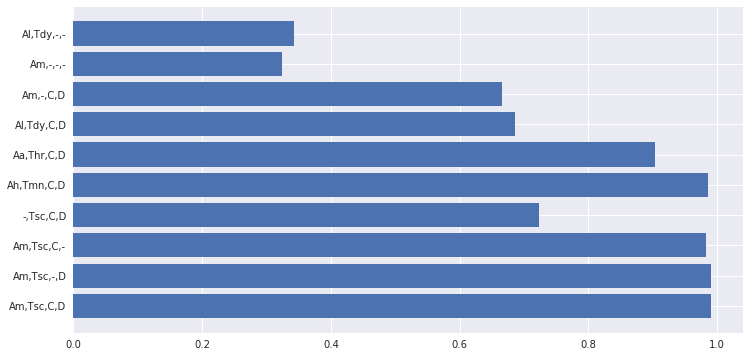

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.figure(figsize=(12,6))
font={'family': 'normal',
     'size':20}
plt.rc('font',**font)
plt.barh(range(len(results)),list(results.values()),tick_label=list(results.keys()))